In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
gld = pd.read_csv('GLD_price.csv', parse_dates=True,index_col=[0])
gld['Close'] = pd.to_numeric(gld['Close'], errors='coerce')

In [3]:
def moving_average_strategy(df, short_period, long_period, rf):
    # Ensure 'Close' column exists
    if 'Close' not in df.columns:
        raise KeyError("The DataFrame must contain a 'Close' column.")

    # Calculate Moving Averages
    df['SMA_Short'] = df['Close'].rolling(window=short_period, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_period, min_periods=1).mean()

    # Strategy Signal: Buy (1) when short MA > long MA, otherwise Hold Cash (0)
    df['Signal'] = np.where(df['SMA_Short'] > df['SMA_Long'], 1, 0)

    # Calculate Daily Returns
    df['Return'] = df['Close'].pct_change()
    
    # Convert risk-free rate to daily
    risk_free_rate = rf / 252
    df['Risk_Free_Return'] = risk_free_rate

    # Strategy Returns: Follow GLD if Signal=1, else earn Risk-Free Return
    df['Strategy_Return'] = df['Signal'].shift(1) * df['Return'] + (1 - df['Signal'].shift(1)) * df['Risk_Free_Return']

    # Fill NaN values (caused by shift operation)
    df['Strategy_Return'].fillna(0)
    df['Return'].fillna(0)

    # Cumulative Returns Calculation
    df['Cumulative_BuyHold'] = (1 + df['Return']).cumprod()
    df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod()

    # Debugging: Ensure columns are properly created
    print("Columns in DataFrame:", df.columns)

    # Compute performance metrics
    strategy_metrics = performance_calc(df, df['Strategy_Return'])
    buy_hold_metrics = performance_calc(df, df['Return'])
    
    # Print Performance Summary
    print(f"{'Metric':<20}{'Strategy':<15}{'Buy & Hold'}")
    print("-" * 50)
    print(f"Annualized Return:  {strategy_metrics[0]:.2%}      {buy_hold_metrics[0]:.2%}")
    print(f"Annualized Volatility:  {strategy_metrics[1]:.2%}      {buy_hold_metrics[1]:.2%}")
    print(f"Sharpe Ratio:  {strategy_metrics[2]:.2f}      {buy_hold_metrics[2]:.2f}")
    print(f"Max Drawdown:  {strategy_metrics[3]:.2%}      {buy_hold_metrics[3]:.2%}")
    
    # Plot Cumulative Returns
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Cumulative_BuyHold'], label='Buy & Hold', linestyle='dashed')
    plt.plot(df.index, df['Cumulative_Strategy'], label='Market Timing Strategy')
    plt.legend()
    plt.title(f"GLD Market Timing vs Buy & Hold ({short_period}-{long_period} MA)")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid()
    plt.show()

def performance_calc(df, returns):
    ann_return = np.prod(1 + returns.dropna()) ** (252 / len(returns)) - 1
    ann_volatility = returns.std() * np.sqrt(252)
    risk_free_rate = df['Risk_Free_Return'].mean()
    sharpe_ratio = (ann_return - risk_free_rate) / ann_volatility  # Adjust Sharpe ratio calculation

    # Ensure 'Cumulative_Strategy' column exists before calculating max drawdown
    if 'Cumulative_Strategy' in df.columns:
        max_drawdown = (df['Cumulative_Strategy'] / df['Cumulative_Strategy'].cummax() - 1).min()
    else:
        max_drawdown = np.nan  # Handle missing column case

    return ann_return, ann_volatility, sharpe_ratio, max_drawdown

Columns in DataFrame: Index(['Close', 'SMA_Short', 'SMA_Long', 'Signal', 'Return',
       'Risk_Free_Return', 'Strategy_Return', 'Cumulative_BuyHold',
       'Cumulative_Strategy'],
      dtype='object')
Metric              Strategy       Buy & Hold
--------------------------------------------------
Annualized Return:  8.15%      9.15%
Annualized Volatility:  10.84%      14.04%
Sharpe Ratio:  0.75      0.65
Max Drawdown:  -11.21%      -11.21%


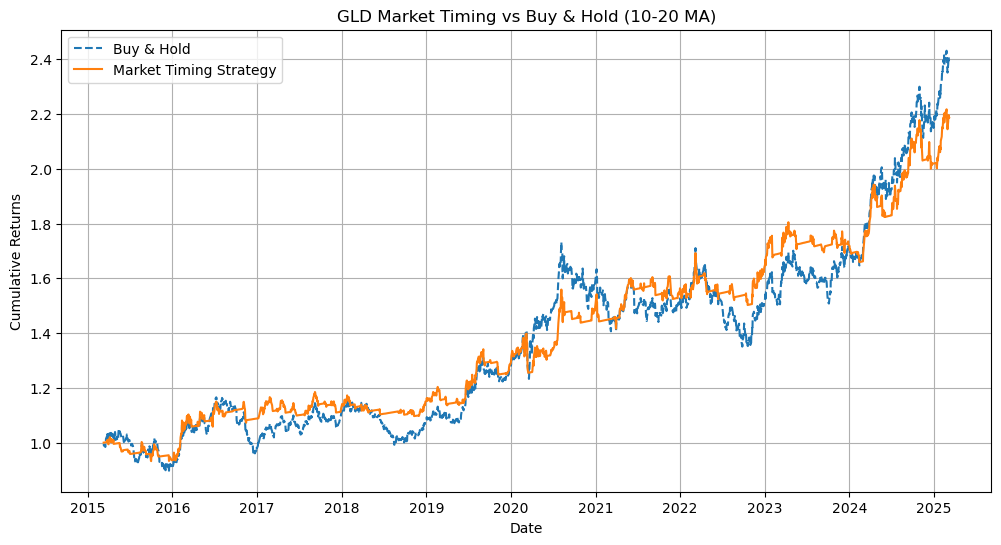

In [89]:
moving_average_strategy(gld, 10, 20, 0.045)

Columns in DataFrame: Index(['Close', 'SMA_Short', 'SMA_Long', 'Signal', 'Return',
       'Risk_Free_Return', 'Strategy_Return', 'Cumulative_BuyHold',
       'Cumulative_Strategy'],
      dtype='object')
Metric              Strategy       Buy & Hold
--------------------------------------------------
Annualized Return:  9.29%      9.15%
Annualized Volatility:  11.87%      14.04%
Sharpe Ratio:  0.78      0.65
Max Drawdown:  -21.76%      -21.76%


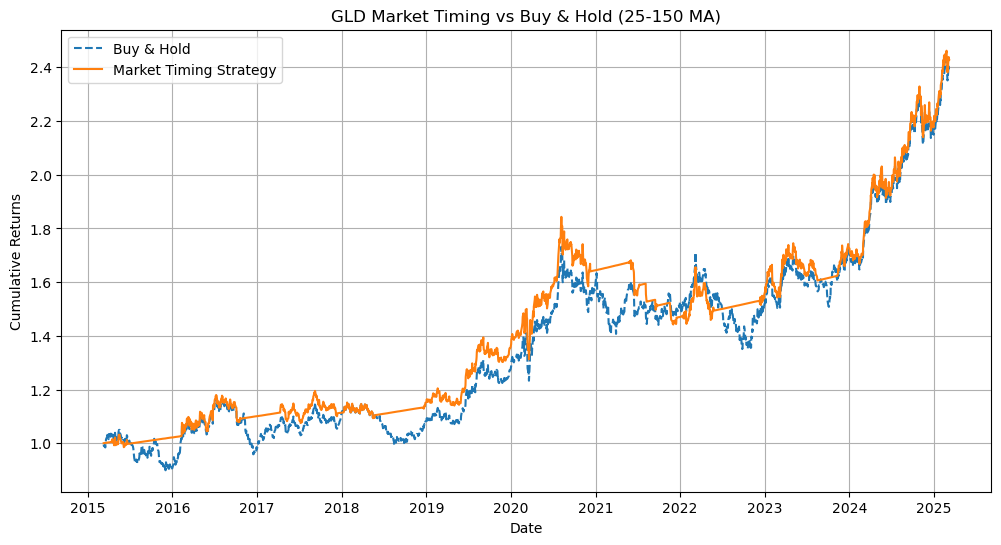

In [35]:
moving_average_strategy(gld, 25, 150, 0.045)

Columns in DataFrame: Index(['Close', 'SMA_Short', 'SMA_Long', 'Signal', 'Return',
       'Risk_Free_Return', 'Strategy_Return', 'Cumulative_BuyHold',
       'Cumulative_Strategy'],
      dtype='object')
Metric              Strategy       Buy & Hold
--------------------------------------------------
Annualized Return:  5.42%      9.15%
Annualized Volatility:  11.72%      14.04%
Sharpe Ratio:  0.46      0.65
Max Drawdown:  -22.67%      -22.67%


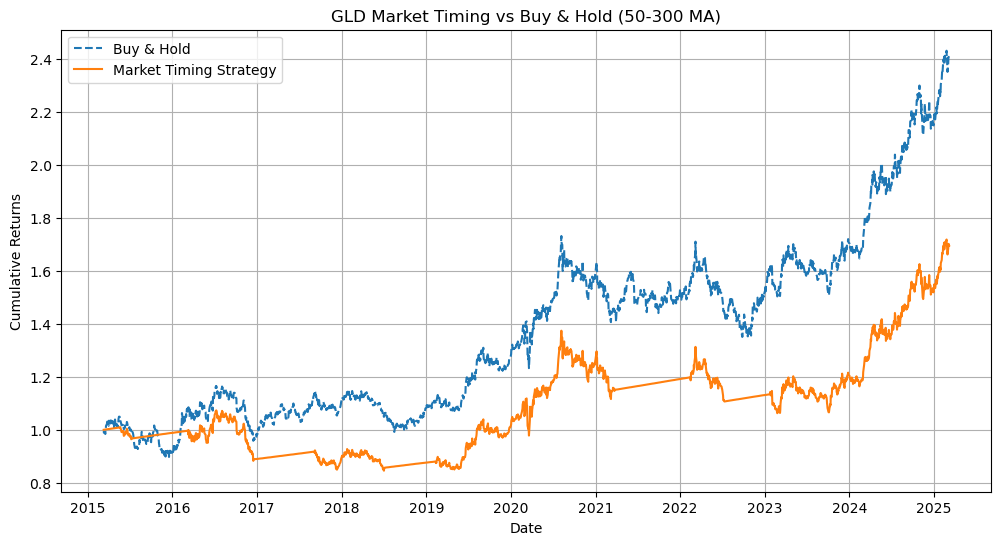

In [49]:
moving_average_strategy(gld, 50, 300, 0.045)

In [91]:
print('The timing signal only helped improve the Sharpe ratio and annualized return for shorter periods, e.g., 10-20 and 25-150. '
      'If we expand the periods to 50-300, we can see the Market Timing Strategy underperforms the Buy & Hold strategy. '
      'Out of the 3 parameter combinations I tried, 25-150 seemed to be giving the best result. However, 10-20 would give us a '
     'much smaller maximum drawdown of about 11%.')


The timing signal only helped improve the Sharpe ratio and annualized return for shorter periods, e.g., 10-20 and 25-150. If we expand the periods to 50-300, we can see the Market Timing Strategy underperforms the Buy & Hold strategy. Out of the 3 parameter combinations I tried, 25-150 seemed to be giving the best result. However, 10-20 would give us a much smaller maximum drawdown.
